### SVM

pip install cvxopt

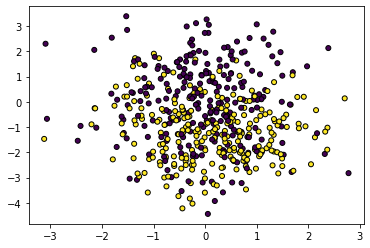

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#generate quite a lot of noise
#with only 4 informative features out of 10
#with 2 redundant features, overlapping with that 4 informative features
#and 4 noisy features
#Also, make std wider using n_clusters=2
X, y = make_classification(n_samples=500, n_features=10, n_redundant=2, n_informative=4,
                             n_clusters_per_class=2, random_state=14)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#look at the data...it is likely not linearly separable!

Accuracy: 1.0


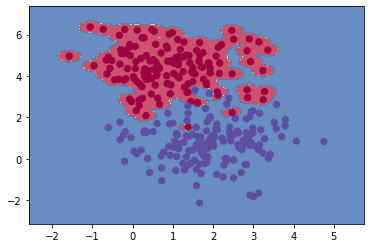

In [9]:
import cvxopt
from sklearn import datasets

#here I use z instead of xprime since I don't know how to write prime in code....
def linear(x, z):
    return np.dot(x, z.T)

def polynomial(x, z, p=5):
    return (1 + np.dot(x, z.T)) ** p

def gaussian(x, z, sigma=0.1):
    return np.exp(-np.linalg.norm(x - z, axis=1) ** 2 / (2 * (sigma ** 2)))

def plot_contour(X, y, svm):
    # plot the resulting classifier
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    points = np.c_[xx.ravel(), yy.ravel()]

    Z = svm.predict(points)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

    # plt the points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)


class SVM:
    def __init__(self, kernel=gaussian, C=1):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        self.y = y
        self.X = X
        m, n = X.shape

        # Calculate Kernel
        self.K = np.zeros((m, m))
        for i in range(m):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)

        # Solve with cvxopt final QP needs to be reformulated
        # to match the input form for cvxopt.solvers.qp
        P = cvxopt.matrix(np.outer(y, y) * self.K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options["show_progress"] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])

    def predict(self, X):  #<----this is X_test
        y_predict = np.zeros((X.shape[0]))
        sv = self.get_parameters(self.alphas)

        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )

        return np.sign(y_predict + self.b)

    def get_parameters(self, alphas):
        threshold = 1e-5

        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(self.X[sv].T, alphas[sv] * self.y[sv, np.newaxis])
        self.b = np.mean(
            self.y[sv, np.newaxis]
            - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis]
        )
        return sv
    
if __name__ == "__main__":
#     X, y = datasets.make_moons(50)
#     print(X.shape,y.shape)
    X, y = make_blobs(n_samples=300, centers=2,
                  random_state=0, cluster_std=1.0)
    
    #transform our y to be -1 and 1 to meet svm purpose
    y[y==0] = -1
    
    svm = SVM(kernel=gaussian)
    svm.fit(X, y)
    y_pred = svm.predict(X)
    plot_contour(X, y, svm)

    print(f"Accuracy: {sum(y==y_pred)/y.shape[0]}")

##### Test1

In [10]:
# Generate data for class 1

mu_1 = np.array([1.0, 2.0])
sigma_1 = 1
num_sample = 100
cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
X1 = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)

# Generate data for class 2

angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(3*sigma_1),np.square(.5*sigma_1),num_sample)
X2 = np.array([X1[:,0] + d*np.cos(angle), X1[:,1] + d*np.sin(angle)]).T

# Combine X1 and X2 into single dataset

X = np.concatenate([X1, X2],axis = 0)
y = np.append(np.zeros(num_sample),np.ones(num_sample))


Accuracy: 1.0


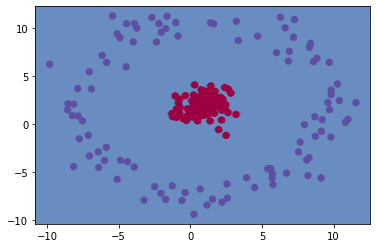

In [11]:
#transform our y to be -1 and 1 to meet svm purpose
y[y==0] = -1

svm = SVM(kernel=gaussian)
svm.fit(X, y)
y_pred = svm.predict(X)
plot_contour(X, y, svm)

print(f"Accuracy: {sum(y==y_pred)/y.shape[0]}")

#### Test3

In [17]:
dataset = [[3.63636364e+00,1.09036800e+00,0], [4.09090909e+00,2.28173256e+00,0], [1.01010101e-01,1.31203345e+00,1], [4.54545455e-01,1.98982144e+00,1], [1.91919192e+00,1.74885201e+00,0], [1.76767677e+00,3.33230999e-01,1], [2.57575758e+00,2.97181157e+00,0], [1.06060606e+00,8.10748756e-01,1], [2.97979798e+00,1.06342392e+00,1], [1.86868687e+00,1.59906946e+00,0], [4.29292929e+00,2.79576184e+00,0], [4.39393939e+00,2.94500082e+00,0], [2.97979798e+00,2.06342392e+00,0], [2.37373737e+00,2.92235429e+00,0], [2.17171717e+00,1.51367739e+00,1], [2.67676768e+00,2.84972543e+00,0], [3.68686869e+00,1.67430145e-01,1], [5.05050505e-01,1.99987413e+00,1], [7.57575758e-01,2.69007901e+00,0], [1.46464646e+00,1.00616154e+00,0], [4.14141414e+00,2.42979491e+00,0], [1.71717172e+00,1.22385354e+00,0], [4.34343434e+00,1.88145336e+00,1], [3.53535354e-01,2.89599377e+00,0], [3.33333333e+00,1.33974596e-01,1], [1.46464646e+00,6.16153554e-03,1], [1.66666667e+00,1.33974596e-01,1], [4.74747475e+00,2.71269417e+00,0], [2.32323232e+00,1.84972543e+00,1], [4.14141414e+00,1.42979491e+00,1], [3.88888889e+00,1.65797986e+00,0], [1.51515152e-01,2.45822652e+00,0], [2.77777778e+00,2.64278761e+00,0], [1.21212121e+00,3.81841014e-01,1], [3.83838384e+00,5.13803264e-01,1], [3.68686869e+00,1.16743015e+00,0], [2.57575758e+00,1.97181157e+00,1], [4.09090909e+00,1.28173256e+00,1], [2.12121212e+00,1.37166246e+00,1], [3.18181818e+00,4.59359183e-01,1], [4.49494949e+00,1.99987413e+00,1], [1.31313131e+00,1.16743015e+00,0], [4.64646465e+00,2.89599377e+00,0], [2.52525253e+00,1.99685478e+00,1], [1.41414141e+00,3.61578414e-02,1], [3.23232323e+00,3.33230999e-01,1], [2.27272727e+00,1.75574957e+00,1], [2.17171717e+00,2.51367739e+00,0], [1.16161616e+00,5.13803264e-01,1], [2.82828283e+00,2.51367739e+00,0], [2.27272727e+00,2.75574957e+00,0], [3.33333333e+00,1.13397460e+00,0], [3.13131313e+00,1.59906946e+00,0], [2.02020202e+00,2.06342392e+00,0], [3.48484848e+00,1.13266082e-03,1], [5.05050505e-01,2.99987413e+00,0], [4.04040404e+00,1.12659245e+00,1], [3.78787879e+00,3.81841014e-01,1], [1.41414141e+00,1.03615784e+00,0], [1.26262626e+00,2.65408291e-01,1], [3.28282828e+00,2.23853536e-01,1], [4.69696970e+00,2.81457595e+00,0], [2.62626263e+00,1.92235429e+00,1], [1.71717172e+00,2.23853536e-01,1], [5.05050505e-02,2.15800140e+00,0], [3.03030303e+00,1.90494396e+00,0], [2.92929293e+00,1.22031053e+00,1], [7.57575758e-01,1.69007901e+00,1], [2.77777778e+00,1.64278761e+00,1], [1.11111111e+00,6.57979857e-01,1], [3.08080808e+00,1.74885201e+00,0], [2.87878788e+00,2.37166246e+00,0], [2.07070707e+00,1.22031053e+00,1], [2.52525253e-01,2.71269417e+00,0], [3.53535354e-01,1.89599377e+00,1], [2.02020202e+00,1.06342392e+00,1], [5.05050505e-02,1.15800140e+00,1], [3.58585859e+00,1.03615784e+00,0], [1.01010101e-01,2.31203345e+00,0], [0.00000000e+00,1.00000000e+00,1], [6.56565657e-01,1.88145336e+00,1], [4.24242424e+00,1.69007901e+00,1], [4.69696970e+00,1.81457595e+00,1], [9.09090909e-01,2.28173256e+00,0], [9.09090909e-01,1.28173256e+00,1], [4.54545455e+00,1.98982144e+00,1], [2.87878788e+00,1.37166246e+00,1], [3.38383838e+00,6.58521397e-02,1], [9.59595960e-01,2.12659245e+00,0], [7.07070707e-01,2.79576184e+00,0], [1.01010101e+00,9.68272067e-01,1], [2.12121212e+00,2.37166246e+00,0], [4.59595960e+00,1.95490224e+00,1], [1.61616162e+00,6.58521397e-02,1], [2.42424242e+00,2.97181157e+00,0], [5.00000000e+00,2.00000000e+00,0], [2.07070707e+00,2.22031053e+00,0], [3.53535354e+00,1.00616154e+00,0], [1.36363636e+00,1.09036800e+00,0], [4.44444444e+00,2.98480775e+00,0], [3.38383838e+00,1.06585214e+00,0], [4.04040404e-01,1.95490224e+00,1], [6.06060606e-01,2.94500082e+00,0], [1.86868687e+00,5.99069465e-01,1], [1.06060606e+00,1.81074876e+00,0], [4.94949495e+00,2.15800140e+00,0], [1.16161616e+00,1.51380326e+00,0], [8.58585859e-01,1.42979491e+00,1], [2.22222222e+00,2.64278761e+00,0], [2.22222222e+00,1.64278761e+00,1], [4.79797980e+00,1.59290793e+00,1], [2.82828283e+00,1.51367739e+00,1], [3.43434343e+00,1.02119755e+00,0], [4.54545455e+00,2.98982144e+00,0], [8.08080808e-01,2.56705986e+00,0], [2.37373737e+00,1.92235429e+00,1], [2.52525253e-01,1.71269417e+00,1], [3.48484848e+00,1.00113266e+00,0], [3.83838384e+00,1.51380326e+00,0], [4.89898990e+00,1.31203345e+00,1], [9.59595960e-01,1.12659245e+00,1], [4.94949495e+00,1.15800140e+00,1], [1.51515152e-01,1.45822652e+00,1], [4.04040404e+00,2.12659245e+00,0], [4.59595960e+00,2.95490224e+00,0], [1.56565657e+00,1.02119755e+00,0], [4.04040404e-01,2.95490224e+00,0], [1.96969697e+00,9.04943957e-01,1], [4.64646465e+00,1.89599377e+00,1], [8.58585859e-01,2.42979491e+00,0], [4.19191919e+00,1.56705986e+00,1], [3.18181818e+00,1.45935918e+00,0], [3.73737374e+00,1.26540829e+00,0], [2.02020202e-01,1.59290793e+00,1], [3.08080808e+00,7.48852013e-01,1], [3.88888889e+00,6.57979857e-01,1], [1.56565657e+00,2.11975538e-02,1], [4.89898990e+00,2.31203345e+00,0], [3.28282828e+00,1.22385354e+00,0], [3.73737374e+00,2.65408291e-01,1], [3.98989899e+00,9.68272067e-01,1], [2.42424242e+00,1.97181157e+00,1], [3.53535354e+00,6.16153554e-03,1], [2.47474747e+00,1.99685478e+00,1], [1.26262626e+00,1.26540829e+00,0], [0.00000000e+00,2.00000000e+00,0], [1.11111111e+00,1.65797986e+00,0], [1.01010101e+00,1.96827207e+00,0], [3.23232323e+00,1.33323100e+00,0], [1.51515152e+00,1.13266082e-03,1], [2.92929293e+00,2.22031053e+00,0], [2.32323232e+00,2.84972543e+00,0], [1.91919192e+00,7.48852013e-01,1], [2.72727273e+00,1.75574957e+00,1], [4.19191919e+00,2.56705986e+00,0], [6.56565657e-01,2.88145336e+00,0], [3.43434343e+00,2.11975538e-02,1], [1.81818182e+00,1.45935918e+00,0], [3.93939394e+00,8.10748756e-01,1], [3.93939394e+00,1.81074876e+00,0], [4.74747475e+00,1.71269417e+00,1], [3.58585859e+00,3.61578414e-02,1], [1.76767677e+00,1.33323100e+00,0], [3.98989899e+00,1.96827207e+00,0], [1.31313131e+00,1.67430145e-01,1], [5.00000000e+00,1.00000000e+00,1], [1.81818182e+00,4.59359183e-01,1], [1.36363636e+00,9.03680046e-02,1], [3.13131313e+00,5.99069465e-01,1], [2.47474747e+00,2.99685478e+00,0], [5.55555556e-01,1.98480775e+00,1], [4.24242424e+00,2.69007901e+00,0], [4.49494949e+00,2.99987413e+00,0], [4.34343434e+00,2.88145336e+00,0], [4.79797980e+00,2.59290793e+00,0], [1.66666667e+00,1.13397460e+00,0], [4.44444444e+00,1.98480775e+00,1], [1.61616162e+00,1.06585214e+00,0], [3.78787879e+00,1.38184101e+00,0], [4.54545455e-01,2.98982144e+00,0], [4.29292929e+00,1.79576184e+00,1], [2.67676768e+00,1.84972543e+00,1], [8.08080808e-01,1.56705986e+00,1], [3.03030303e-01,1.81457595e+00,1], [3.03030303e-01,2.81457595e+00,0], [1.96969697e+00,1.90494396e+00,0], [6.06060606e-01,1.94500082e+00,1], [3.63636364e+00,9.03680046e-02,1], [1.51515152e+00,1.00113266e+00,0], [1.21212121e+00,1.38184101e+00,0], [5.55555556e-01,2.98480775e+00,0], [4.84848485e+00,1.45822652e+00,1], [7.07070707e-01,1.79576184e+00,1], [2.52525253e+00,2.99685478e+00,0], [4.39393939e+00,1.94500082e+00,1], [2.72727273e+00,2.75574957e+00,0], [2.62626263e+00,2.92235429e+00,0], [4.84848485e+00,2.45822652e+00,0], [2.02020202e-01,2.59290793e+00,0], [3.03030303e+00,9.04943957e-01,1]]

Accuracy: 1.0


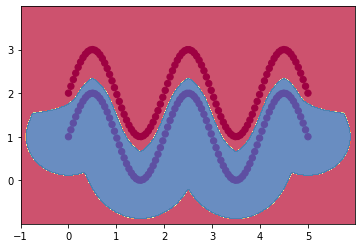

In [26]:
dataset = np.array(dataset)
X = dataset[:,:2]
y = dataset[:,-1]
#transform our y to be -1 and 1 to meet svm purpose
y[y==0] = -1

svm = SVM(kernel=gaussian)
svm.fit(X, y)
y_pred = svm.predict(X)
plot_contour(X, y, svm)

print(f"Accuracy: {sum(y==y_pred)/y.shape[0]}")

#### Test2 (PRIMAL FORM)

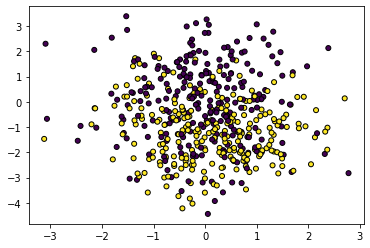

In [14]:
#generate quite a lot of noise
#with only 4 informative features out of 10
#with 2 redundant features, overlapping with that 4 informative features
#and 4 noisy features
#Also, make std wider using n_clusters=2
X, y = make_classification(n_samples=500, n_features=10, n_redundant=2, n_informative=4,
                             n_clusters_per_class=2, random_state=14)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#look at the data...it is likely not linearly separable!

In [16]:
import numpy as np
from sklearn.metrics import average_precision_score, classification_report
from sklearn.preprocessing import StandardScaler

def mini_batch_GD(X, y, max_iter=1000):
    w = np.zeros(X.shape[1])
    l_rate = 0.00001
    batch_size = int(0.1 * X.shape[0])
    for i in range(max_iter):
        ix = np.random.randint(0, X.shape[0])
        batch_X = X[ix:ix+batch_size]
        batch_y = y[ix:ix+batch_size]
        #becareful the sign is "+" l_rate since i have already inverted 
        #the sign in gradient()
        for i, x in enumerate(batch_X):
            w = w + l_rate * gradient(batch_X[i], batch_y[i], w)
    return w, i

def gradient(x, y, w):
    lamb = 0.01
    if (y * (x @ w)) < 1:
        return (x * y) + (-2 * lamb * w)
    else:
        return -2 * lamb * w
        
def get_pred(X, w):
    #use np.sign if our input y is -1 and 1
    return np.sign(X @ w)

#transform our y to be -1 and 1 to meet svm purpose
y_train_minus = y_train.copy()
y_test_minus = y_test.copy()
y_train_minus[y_train_minus==0] = -1
y_test_minus[y_test_minus==0] = -1

#if the training data is not scaled properly,
#since svm is a widest street algorithm, SVM will tend 
#to neglect small features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

w, i = mini_batch_GD(X_train_standardized, y_train_minus, max_iter=10000)
pred = get_pred(X_test_standardized, w)

print("APS: ", average_precision_score(y_test_minus, pred))
print("Report: ", classification_report(y_test_minus, pred))



APS:  0.7611791565941446
Report:                precision    recall  f1-score   support

          -1       0.80      0.86      0.83        77
           1       0.84      0.78      0.81        73

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



#### Sklearn

In [12]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

#this code will run very long time!!!

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
assert X_train.shape[0] == y_train.shape[0]

#select the type of hyperplane used to separate the data
kernel = ['linear', 'rbf']

#regularized penalty
#when C is small, classifier is ok with misclassified data
#when C is large, classifier is heavily penalized for misclassified data
C_range = [1, 2]

#parameter for RBF kernel, increasing gamma
#allows for more complex decision boundary but can lead
#to overfitting
gamma_range = [0.0001, 0.0005]

param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("=========Best parameters=======")
print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

model.fit(X_train, y_train)
yhat = model.predict(X_test) #svm use this instead

#plot precision recall curve
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix
print("=========Average precision score=======")
print(average_precision_score(y_test, yhat))
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

"""
If you want better score, try larger range of params...I tried only a few so not to slow
down my computer.
"""

=========Best parameters=======
The best parameters are {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'} witha score of 0.64
=========Average precision score=======
0.6725806451612903
=========Classification report=======
Report:                precision    recall  f1-score   support

        -1.0       0.58      1.00      0.73        29
         1.0       1.00      0.32      0.49        31

    accuracy                           0.65        60
   macro avg       0.79      0.66      0.61        60
weighted avg       0.80      0.65      0.61        60



'\nIf you want better score, try larger range of params...I tried only a few so not to slow\ndown my computer.\n'